In [1]:
import numpy as np
import random
import IPython.display
import PIL.Image
from io import BytesIO

In [2]:
class Coordinate(object):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def step(self, direction):
        return Coordinate(
            self.x + direction.x, 
            self.y + direction.y
        )
        
    def __repr__(self):
        return f"Coordinate({self.x}, {self.y})"
        
    def __eq__(self, obj):
        return self.x == obj.x and self.y == obj.y
        
    def __hash__(self):
        return hash((self.x, self.y))
        
directions = [Coordinate(x,y) for x,y in [(0,1), (0,-1), (1,0), (-1,0)]]

In [3]:
class Digger(object):
    
    def __init__(self,maze,location,seed=101):
        np.random.seed(seed)
        self.maze = maze
        self.location = location
        self.maze.enter_cell(location)
        self.walk = [location]
        
    def walk_maze(self):
        while len(self.walk):
            possible_steps = self.maze.available_steps(self.location)
            if len(possible_steps) == 0:
                self.location = self.walk.pop()
                continue
            next_step = np.random.choice(possible_steps, 1)[0]
            self.maze.dig_step(self.location, next_step)
            self.location = next_step
            self.walk.append(self.location)
            
            
class Maze(object):
    
    def __init__(self, *, size=50, render_size=800, seed=101):
        self.render_size = render_size
        self.N = size
        self.space = np.zeros([self.N,self.N], dtype=np.bool)
        self.visitable_cells = set([Coordinate(x,y) for x in range(1,self.N-1) for y in range(1,self.N-1)])
        Digger(self,Coordinate(1,1),seed).walk_maze()
        
    def enter_cell(self, location):
        self.space[location.x, location.y] = True
        self.visitable_cells.discard(location)
    
    def dig_step(self, location, new_location):
        self.space[new_location.x, new_location.y] = True
        self.visitable_cells.discard(new_location)
        
    def available_steps(self, location):
        possible_cells = [location.step(d) for d in directions]
        possible_cells = [c for c in possible_cells if c in self.visitable_cells]

        step_cells = []
        for c in possible_cells:
            neighbours = [c.step(d) for d in directions]
            valid = True
            for n in neighbours:
                # Don't double back or join up existing paths.
                if n != location and self.space[n.x, n.y]==True:
                    valid = False
                    break
            if valid:
                step_cells.append(c)
        
        return step_cells

    @property
    def img(self): 
        img = PIL.Image.fromarray(self.space).resize(
                  (self.render_size, self.render_size), 
                  PIL.Image.BOX
              )
        return img
    
    def save(self, path):  
        self.img.save(path, format='png')
    
    def _repr_png_(self):       
        b = BytesIO()
        self.img.save(b, format='png')
        return b.getvalue()

    

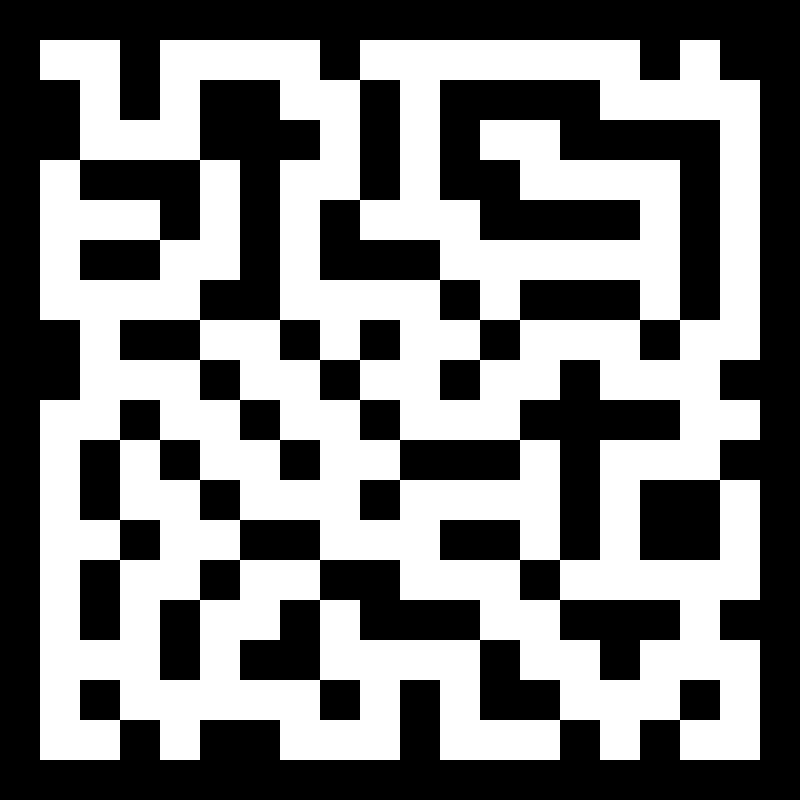

In [9]:
Maze(size=20,seed=2)

In [16]:
for seed in [1,2,3,4,5]:
    Maze(size=60, seed=seed).save(f"maze-60-{seed}.png")